In [9]:
!pip install optuna

  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/4c/6a/219a431aaf81b3eb3070fd2d58116baa366d3072f43bbcc87dc3495b7546/optuna-3.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/7f/50/9fb3a5c80df6eb6516693270621676980acd6d5a9a7efdbfa273f8d616c7/alembic-1.13.1-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/95/df/520663eb7f7a329f7c585834b754bcc3cbcc03957d85fcbba4a2a723ad9d/colorlog-6.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/24/3b/11fe92d68c6a42468ddab0cf03f454419b0788fff4e91ba46b8bebafeffd/Mako-1.3.0-py3-none-any.whl.metadata
   ---------------------------------------- 413.4/413.4 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 233.4/233.4 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pickle
import json
import optuna
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score

In [11]:
df = pd.read_csv("rr_train.csv")
df.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [13]:
df['Open Date'] = pd.to_datetime(df['Open Date'], format='%m/%d/%Y')

In [14]:
today = pd.Timestamp.now().to_period('D')
last_date = pd.to_datetime('03/29/2021', format='%m/%d/%Y')
df['num_open_days'] = (last_date - df['Open Date']).dt.days

In [15]:
df = df.drop('Open Date', axis=1)

<AxesSubplot:xlabel='City Group', ylabel='revenue'>

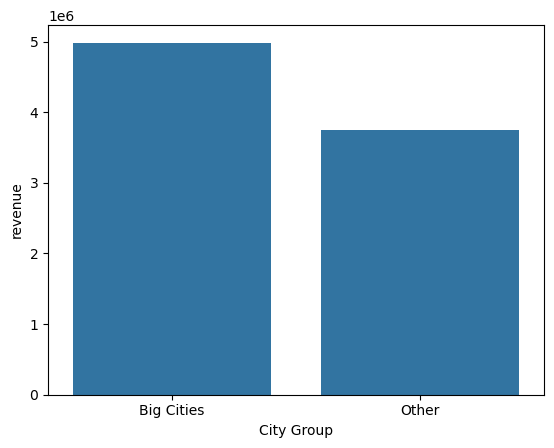

In [16]:
revenue_percentage = df[["City Group", "revenue"]].groupby(['City Group'], as_index=False).mean()
sns.barplot(x='City Group', y='revenue', data=revenue_percentage)

In [17]:
revenue_percentage = df[["City", "revenue"]].groupby(["City"], as_index=False).mean()
sorted_revenue = revenue_percentage.sort_values(["revenue"], ascending=False)
print(sorted_revenue)

              City       revenue
31        İstanbul  5.577812e+06
12          Elazığ  5.525735e+06
11          Edirne  5.444227e+06
32           İzmir  5.287571e+06
29         Trabzon  5.284100e+06
1   Afyonkarahisar  4.952497e+06
0            Adana  4.894944e+06
6        Balıkesir  4.758476e+06
18         Kayseri  4.567576e+06
14       Gaziantep  4.316715e+06
7             Bolu  4.263629e+06
23           Muğla  4.111129e+06
8            Bursa  4.092295e+06
15         Isparta  4.015749e+06
13       Eskişehir  3.957953e+06
16         Karabük  3.807496e+06
19         Kocaeli  3.745135e+06
10      Diyarbakır  3.735351e+06
4          Antalya  3.481448e+06
5            Aydın  3.429798e+06
24        Osmaniye  3.376145e+06
25         Sakarya  3.328853e+06
27        Tekirdağ  3.312471e+06
3           Ankara  3.275406e+06
17       Kastamonu  3.273041e+06
33       Şanlıurfa  3.261924e+06
26          Samsun  3.247870e+06
21         Kütahya  2.993069e+06
2           Amasya  2.954086e+06
28        

In [18]:
df = df.drop(['Id', 'Type', 'City'], axis=1)

In [19]:
revenue = df['revenue']
df = df.drop('revenue', axis=1)

In [20]:
df = pd.get_dummies(df)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df, revenue, test_size=0.25, random_state=42)

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_features = trial.suggest_int('max_features', 3, 7)
    
    rf = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=3, n_jobs=8, scoring='r2')
    return -scores.mean()

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-12-24 10:51:03,885] A new study created in memory with name: no-name-d1c704cc-9123-4365-a2bd-d3bcc44c40e2
[I 2023-12-24 10:52:10,085] Trial 0 finished with value: 0.17132917233249398 and parameters: {'n_estimators': 511, 'max_features': 6}. Best is trial 0 with value: 0.17132917233249398.
[I 2023-12-24 10:52:42,904] Trial 1 finished with value: 0.10171472737889982 and parameters: {'n_estimators': 803, 'max_features': 3}. Best is trial 0 with value: 0.17132917233249398.
[I 2023-12-24 10:53:10,567] Trial 2 finished with value: 0.1114135573003655 and parameters: {'n_estimators': 763, 'max_features': 4}. Best is trial 0 with value: 0.17132917233249398.
[I 2023-12-24 10:53:17,909] Trial 3 finished with value: 0.12216410543725457 and parameters: {'n_estimators': 908, 'max_features': 7}. Best is trial 0 with value: 0.17132917233249398.
[I 2023-12-24 10:53:23,958] Trial 4 finished with value: 0.10296733954344994 and parameters: {'n_estimators': 852, 'max_features': 3}. Best is trial 0 

In [25]:
best_params = study.best_params

In [26]:
final_rf = RandomForestRegressor(**best_params, random_state=42)
final_rf.fit(X_train, y_train)

RandomForestRegressor(max_features=6, n_estimators=11, random_state=42)

In [27]:
train_score = final_rf.score(X_train, y_train)
test_score = final_rf.score(X_test, y_test)
print("Train R-squared:", train_score)
print("Test R-squared:", test_score)

Train R-squared: 0.8488532395467836
Test R-squared: 0.05084555737733765


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10200\3007069422.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(revenue))


<AxesSubplot:xlabel='revenue', ylabel='Density'>

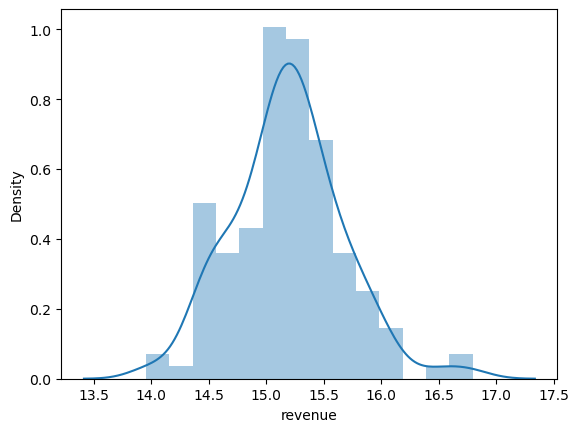

In [28]:
sns.distplot(np.log(revenue))

In [29]:
pca = PCA(n_components=2, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(pca.explained_variance_ratio_)

[0.50853205 0.1615744 ]


In [30]:
kpca = KernelPCA(kernel="rbf", gamma=1)
X_train_kpca = kpca.fit_transform(X_train)
X_test_kpca = kpca.transform(X_test)

Text(0.5, 0, 'After RBF KernelPCA')

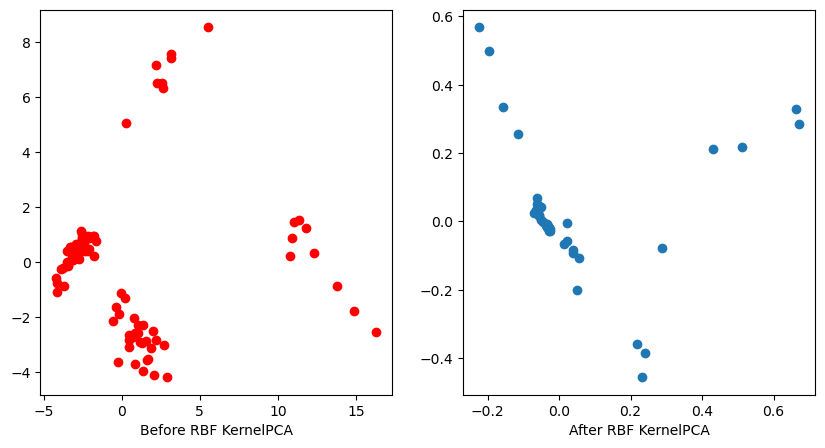

In [31]:
# Visualize the data before and after RBF KernelPCA
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], color='red', marker='o')
ax[1].scatter(X_train_kpca[:, 0], X_train_kpca[:, 1])
ax[0].set_xlabel('Before RBF KernelPCA')
ax[1].set_xlabel('After RBF KernelPCA')


In [32]:
def pca_objective(trial):
    n_components = trial.suggest_int('n_components', 1, min(X_train.shape[1], X_train.shape[0]))
    
    pca = PCA(n_components=n_components, svd_solver='full')
    X_train_pca = pca.fit_transform(X_train)
    
    rf = RandomForestRegressor(**best_params, random_state=42)
    scores = cross_val_score(rf, X_train_pca, y_train, cv=3, n_jobs=8, scoring='r2')
    
    return -scores.mean()

In [33]:
study_pca = optuna.create_study(direction='maximize')
study_pca.optimize(pca_objective, n_trials=100)

[I 2023-12-24 12:18:41,827] A new study created in memory with name: no-name-804a2bad-d98e-46a2-9148-6c082df67fd0
[I 2023-12-24 12:20:09,734] Trial 0 finished with value: 0.2456802284110798 and parameters: {'n_components': 19}. Best is trial 0 with value: 0.2456802284110798.
[I 2023-12-24 12:20:44,242] Trial 1 finished with value: 0.16181740870641514 and parameters: {'n_components': 7}. Best is trial 0 with value: 0.2456802284110798.
[I 2023-12-24 12:21:07,785] Trial 2 finished with value: -0.008187990793953381 and parameters: {'n_components': 29}. Best is trial 0 with value: 0.2456802284110798.
[I 2023-12-24 12:21:08,053] Trial 3 finished with value: 0.26539158417482284 and parameters: {'n_components': 24}. Best is trial 3 with value: 0.26539158417482284.
[I 2023-12-24 12:21:08,270] Trial 4 finished with value: 0.26539158417482284 and parameters: {'n_components': 24}. Best is trial 3 with value: 0.26539158417482284.
[I 2023-12-24 12:21:09,353] Trial 5 finished with value: 0.1076409952

In [34]:
best_pca_components = study_pca.best_params['n_components']

In [35]:
pca = PCA(n_components=best_pca_components, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [36]:
final_rf_pca = RandomForestRegressor(**best_params, random_state=42)
final_rf_pca.fit(X_train_pca, y_train)

RandomForestRegressor(max_features=6, n_estimators=11, random_state=42)

In [37]:
train_score_pca = final_rf_pca.score(X_train_pca, y_train)
test_score_pca = final_rf_pca.score(X_test_pca, y_test)
print("Train R-squared (PCA):", train_score_pca)
print("Test R-squared (PCA):", test_score_pca)

Train R-squared (PCA): 0.8381481210918975
Test R-squared (PCA): -0.011167542157701993
